# What is Dask? 

(Working on the intro)

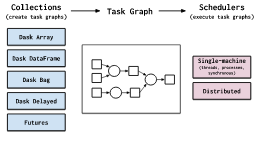


Here are the basic aspects of Dask, according to dask's package maintainers:
- process data that doesn't fit into memory by breaking it into blocks and specifying task chains
- parallelize execution of tasks across cores and even nodes of a cluster
- move computation to the data rather than the other way around, to minimize communication overhead




Simplest dask example

Let us first open a single R-CESM ROMS model output file, containing 8 time steps, using xarray. 

In [3]:
import xarray as xr
import time
from glob import glob
import xroms
%matplotlib inline

file = '/ihesp/user/liu6/GOM_9k_nature_copernicus/Orig/cmpr_GOM_9k_nature_copernicus.ocn.hi.2016-05-22_03:00:00.nc'
ds = xr.open_dataset(file)
ds.temp

<xarray.DataArray 'temp' (ocean_time: 8, s_rho: 50, eta_rho: 489, xi_rho: 655)>
[128118000 values with dtype=float32]
Coordinates:
  * s_rho       (s_rho) float64 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
  * ocean_time  (ocean_time) datetime64[ns] 2016-05-22T03:00:00 ... 2016-05-23
    lon_rho     (eta_rho, xi_rho) float64 ...
    lat_rho     (eta_rho, xi_rho) float64 ...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  potential temperature
    units:      Celsius
    time:       ocean_time
    field:      temperature, scalar, series

<hr style="border:2px solid gray"> </hr>

We print the value of ds.temp to see that is an object of type xarray.DataArray, with dimensions (ocean_time: 8, s_rho: 50, eta_rho: 489, xi_rho: 655). The actual temperature data is stored as a numpy.ndarray object containing 128118000 elements. 

Next, we compute the mean of all fields across two dimensions. We use the IPython magic command **%%time** to print the time of execution of the cell. 

In [6]:
%%time
average_ds=ds.mean(['ocean_time','s_rho'])
ds.close()

CPU times: user 4.97 s, sys: 1.62 s, total: 6.59 s
Wall time: 6.62 s


The above command loaded all the fields into the memory space in which this jupyter notebook is running, and the actual computation occurs on 1 core. If we tried to load too many files at the same time, the notebook may run out of memory and crash. This is where Dask comes in. Let us look at how to open a file using xarray with dask. 

Since, xarray natively supports the dask library, we only need to specify *chunks='auto'* to make use of dask

In [4]:
ds = xr.open_dataset(file,chunks='auto')
ds.temp

<xarray.DataArray 'temp' (ocean_time: 8, s_rho: 50, eta_rho: 489, xi_rho: 655)>
dask.array<open_dataset-e9b9fca5988377ea01525ac13e9ca44dtemp, shape=(8, 50, 489, 655), dtype=float32, chunksize=(8, 50, 163, 289), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
  * ocean_time  (ocean_time) datetime64[ns] 2016-05-22T03:00:00 ... 2016-05-23
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(489, 655), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(489, 655), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  potential temperature
    units:      Celsius
    time:       ocean_time
    field:      temperature, scalar, series

Notice how different this *temp* field is compared to the previous method. The data in ds.temp is no longer a simple numpy.ndarray, but it is instead split into 9 chunks of size (8, 50, 163, 289) each.  

## Lazy loading and basic Parallelism

The most important aspect of this *temp* field is that much of the data that xarray 'sees' at this point only exists on disk storage and is not actually loaded into the memory (RAM). At this stage, xarray/dask is only aware of a basic amount of information enough to start performing tasks on the dataset. Dask automatically loads data according to the chunk size from disk storage into RAM as required for each computation. This is known as *lazy loading*. This is unlike the previous method (without the chunk='auto' argument), which would load the entire file(s) into memory. 

**A huge advantage of lazy loading is that we can potentially invoke computations on entire high-resolution datasets that far exceed the amount of memory available to us.**

In addition to lazy loading, dask also enforces 


In [7]:
%%time
import dask
average_ds=ds.mean(['ocean_time','s_rho'])

CPU times: user 85 ms, sys: 1 ms, total: 86 ms
Wall time: 84.7 ms


Note how the above operation finishes in the order of milliseconds. However, the above command did not actually compute the mean. It has only generated the task graphs at this point. To actually force the computation, do

In [8]:
average_ds.compute()

/ihesp/shared/conda/envs/jupyterlab_env/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:      (boundary: 4, eta_psi: 488, eta_rho: 489, eta_u: 489, eta_v: 488, s_w: 51, tracer: 2, xi_psi: 654, xi_rho: 655, xi_u: 654, xi_v: 655)
Coordinates:
  * s_w          (s_w) float64 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
    lon_rho      (eta_rho, xi_rho) float64 -97.94 -97.92 ... -79.19 -79.16
    lat_rho      (eta_rho, xi_rho) float64 18.13 18.13 18.13 ... 30.85 30.85
    lon_u        (eta_u, xi_u) float64 -97.93 -97.9 -97.87 ... -79.21 -79.18
    lat_u        (eta_u, xi_u) float64 18.13 18.13 18.13 ... 30.85 30.85 30.85
    lon_v        (eta_v, xi_v) float64 -97.94 -97.92 -97.89 ... -79.19 -79.16
    lat_v        (eta_v, xi_v) float64 18.15 18.15 18.15 ... 30.84 30.84 30.84
    lon_psi      (eta_psi, xi_psi) float64 -97.93 -97.9 -97.87 ... -79.21 -79.18
    lat_psi      (eta_psi, xi_psi) float64 18.15 18.15 18.15 ... 30.84 30.84
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes       float64 8.64e+03
    ndtfast      float64 30.0
    dt           float64 30.0
    dtfast       float64 1.0
    nHIS         float64 360.0
    ndefHIS      float64 2.88e+03
    nRST         float64 8.64e+03
    ntsAVG       float64 1.0
    nAVG         float64 360.0
    ndefAVG      float64 2.88e+03
    ntsDIA       float64 1.0
    nDIA         float64 360.0
    ndefDIA      float64 2.88e+03
    Falpha       float64 2.0
    Fbeta        float64 4.0
    Fgamma       float64 0.284
    nl_tnu2      (tracer) float64 15.0 15.0
    nl_visc2     float64 15.0
    Akt_bak      (tracer) float64 1e-06 1e-06
    Akv_bak      float64 1e-05
    rdrg         float64 0.0003
    rdrg2        float64 0.003
    Zob          float64 0.02
    Zos          float64 0.02
    Znudg        float64 0.5
    M2nudg       float64 0.1
    M3nudg       float64 0.1
    Tnudg        (tracer) float64 0.5 0.5
    FSobc_in     (boundary) float64 0.0 0.0 0.0 0.0
    FSobc_out    (boundary) float64 0.0 0.0 0.0 0.0
    M2obc_in     (boundary) float64 0.0 0.0 0.0 0.0
    M2obc_out    (boundary) float64 0.0 0.0 0.0 0.0
    Tobc_in      (boundary, tracer) float64 0.0 0.0 ... 5.787e-05 5.787e-05
    Tobc_out     (boundary, tracer) float64 0.0 0.0 ... 5.787e-06 5.787e-06
    M3obc_in     (boundary) float64 0.0 1.157e-05 1.157e-05 1.157e-05
    M3obc_out    (boundary) float64 0.0 1.157e-06 1.157e-06 1.157e-06
    rho0         float64 1.025e+03
    gamma2       float64 1.0
    spherical    float64 1.0
    xl           float64 1.983e+06
    el           float64 1.413e+06
    Vtransform   float64 2.0
    Vstretching  float64 4.0
    theta_s      float64 10.0
    theta_b      float64 2.0
    Tcline       float64 400.0
    hc           float64 400.0
    Cs_r         float64 -0.1523
    Cs_w         (s_w) float64 -1.0 -0.9316 -0.8539 ... -4.215e-06 0.0
    h            (eta_rho, xi_rho) float64 15.0 15.0 15.0 ... 754.5 757.9 762.1
    f            (eta_rho, xi_rho) float64 4.539e-05 4.539e-05 ... 7.478e-05
    pm           (eta_rho, xi_rho) float64 0.0003298 0.0003298 ... 0.0003651
    pn           (eta_rho, xi_rho) float64 0.0003298 0.0003298 ... 0.0003651
    angle        (eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mask_rho     (eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_u       (eta_u, xi_u) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_v       (eta_v, xi_v) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_psi     (eta_psi, xi_psi) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    zeta         (eta_rho, xi_rho) float32 nan nan nan ... 0.34744292 0.34744292
    ubar         (eta_u, xi_u) float32 nan nan nan ... 0.20994018 0.1544091
    vbar         (eta_v, xi_v) float32 nan nan nan ... 0.34209314 0.2856431
    u            (eta_u, xi_u) float32 nan nan nan ... 0.23698652 0.18649314
    v            (eta_v, xi_v) float32 nan nan nan ... 0.43680328 0.38452014
    w            (s_w, eta_rho, xi_rho) float32 na

The *compute()* operation forces dask to compute all the pending tasks and return the result to the jupyter notebook or python script from which it is called. In this case, the memory available to the notebook and the dask workers are exactly the same. We will also see examples where the dask workers are running on vasly bigger computational resources compared to the jupyter notebook. In such cases, calling compute() without careful forethough could potentially lead to the notebook running out of memory and crashing. 

When ds.mean is called, dask first partitions this mean operation into a series of small tasks to operate on each chunk. Below is an example of a dask graph generated when we call the mean operation on the temperature field in the dataset. 

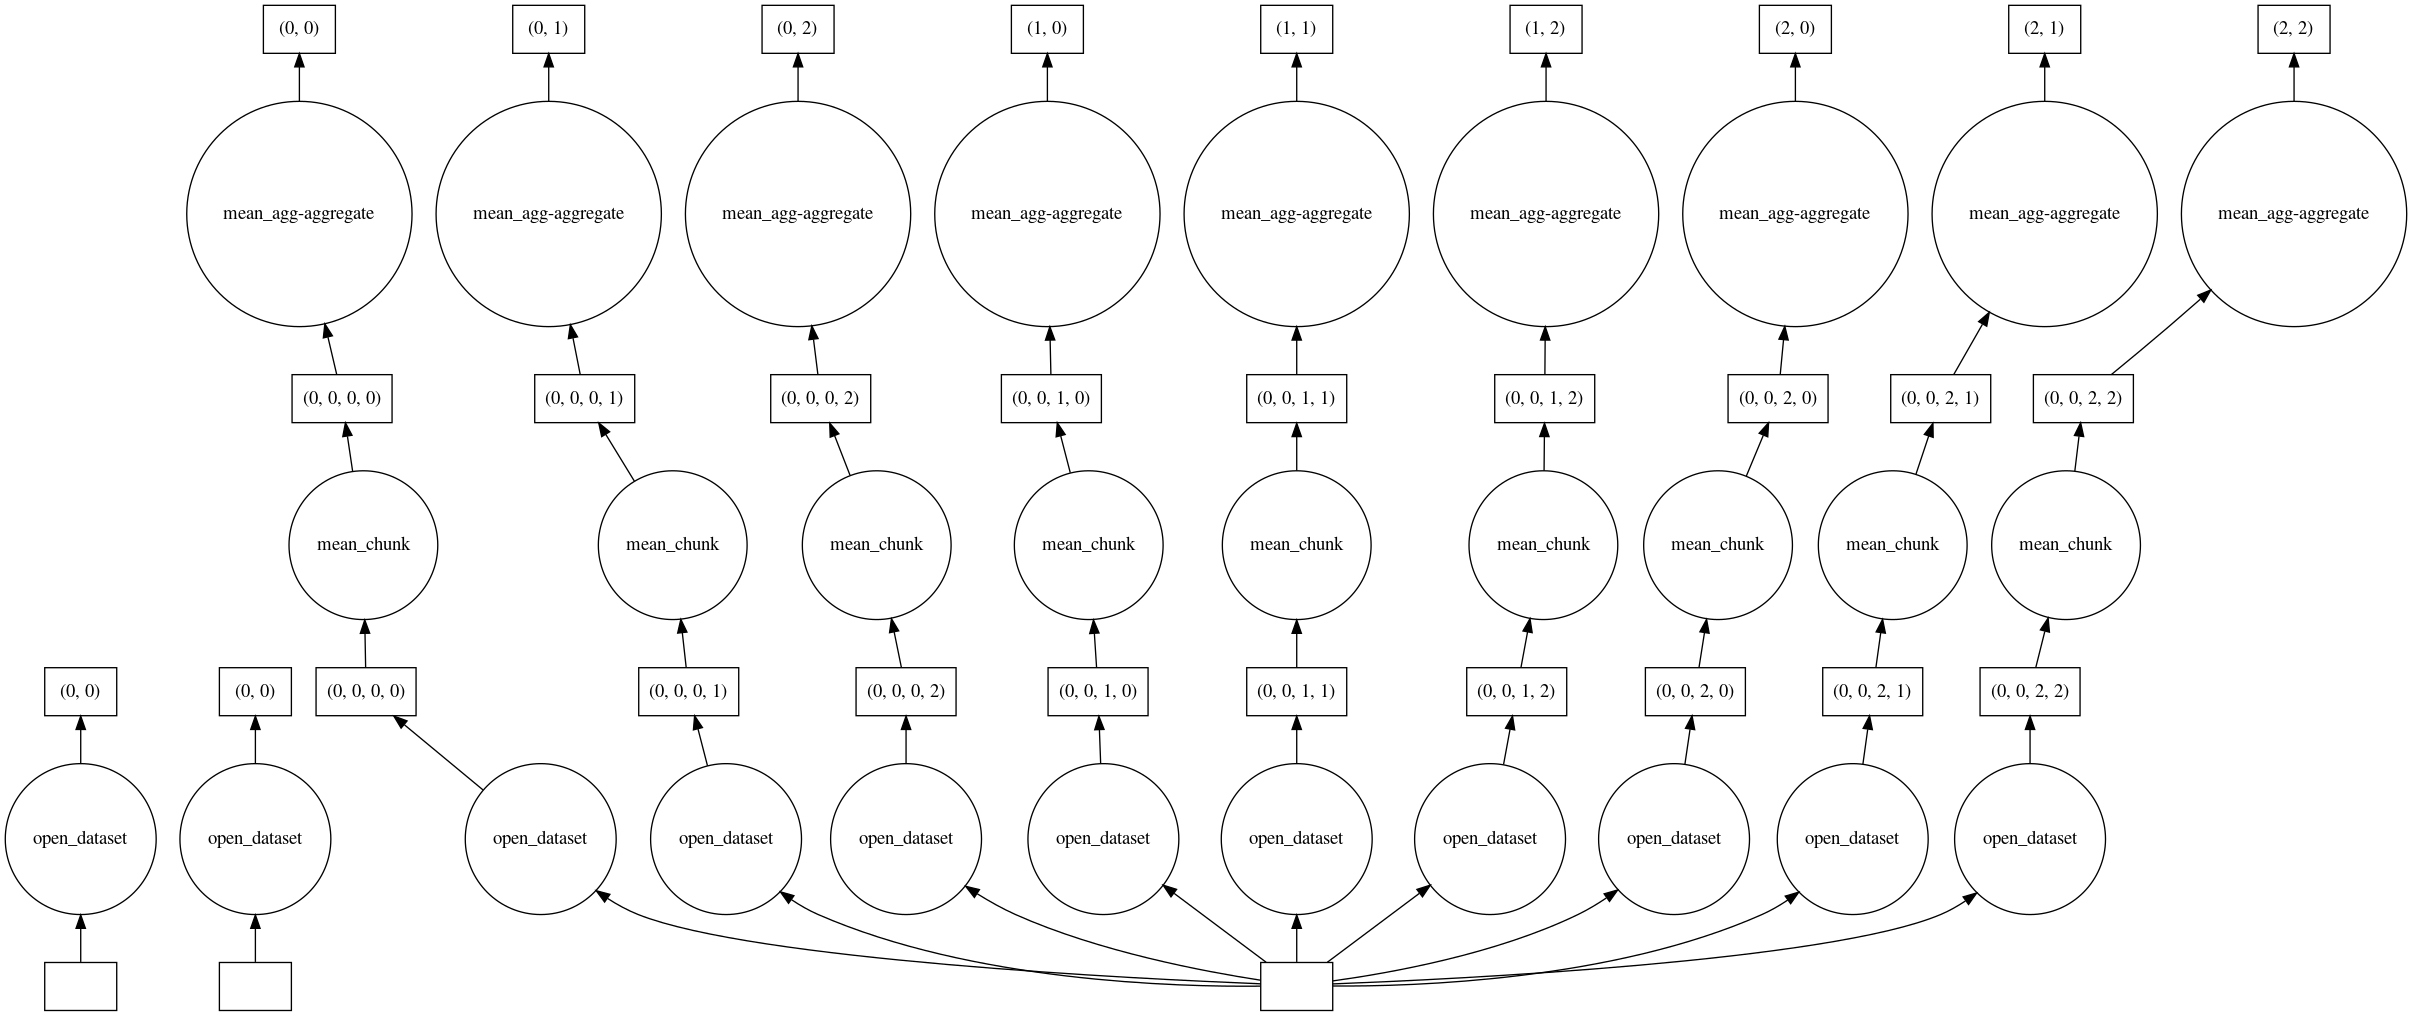

In [17]:
dask.visualize(ds.temp.mean(['ocean_time','s_rho']))

As we saw previously, there are 9 chunks in the dataset we opened. Dask loads each chunk into memory, and calls the mean_chunk function to generate the required sum and number of elements in the chunk, and aggregates the values in the mean_agg step. 

During the compute() operation, the dask scheduler basically assigns or schedules each task in the graph (circle) to operate on data (rectangle). The scheduler optimally assigns tasks to processors that already have the respective chunk in memory. When it runs out of new chunks to process, dask loads more chunks into memory through open_dataset. Since dask assigns these tasks to all available processors by default, this mean operation we just executed is inherently parallel.

## What is a thread, process, worker, cores

In [2]:
TBF

Client Scheduler: tcp://10.70.19.8:34053 Dashboard: http://10.70.19.8:8787/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GB


## Dask performance report

In [10]:
with performance_report(filename="report_hengkai_salt_4.html"):
    ds.compute()



CPU times: user 3.44 s, sys: 252 ms, total: 3.69 s
Wall time: 1min 58s


In [24]:
client.shutdown()

## When is Dask not useful